# **Projeto SUPER AmAs 2020**
## Curso/Módulo 3 - Introdução ao Aprendizado Profundo
## **Aluno**: Enéas Mesquita
## **Pós-graduação**: Mestrado
# ---------------------------------------------------

# **Codificação de uma rede profunda ResNet18**

Implementar uma rede neural profunda chamada ResNet18 seguindo a arquitetura proposta no artigo https://arxiv.org/pdf/1512.03385v1.pdf  (observe a tabela 1 e as figuras 3c e 5a).

Treinar essa rede neural usando o dataset cats and dogs.

* Entregar um arquivo jupyter notebook que possa ser 
carregado no colabresearch (não devem existir bugs).
* O notebook deve ser comentado e cada decisão adotada na implementação do modelo deve ser justificada.
* Deve-se seguir "fielmente" o modelo proposto no artigo original da arquitetura ResNet, caso existam divergências na implementação estas devem ser devidamente justificadas.
* A **abordagem de data augmentation deve ser utilizada, mas sem resizing e rescaling**
* Incorporar o rescaling e resizing como camadas na rede usando o Experimental layers do Keras (https://keras.io/api/layers/preprocessing_layers/)
* Faça plots de treinamento e calcule as métricas.

# **Data de entrega: 27/10/2020 (terça-feira)**

# **Manipulando o dataset cats_and_dogs**


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import experimental
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform

print(keras.__version__)

2.4.0


## **Trabalhando com o dataset cats vs dogs do TF pois é o mesmo disponível no kaggle, porém, sem imagens corrompidas**

In [ ]:
import tensorflow_datasets as tfds
tfds.__version__

'4.0.1'

In [ ]:
splits = ['train[:80%]','train[80%:90%]','train[90%:]']
(treino_ds, validacao_ds, teste_ds), ds_info = tfds.load('cats_vs_dogs', split=splits, with_info=True, as_supervised=True)

print("Numero de exemplares para treino: %d" % tf.data.experimental.cardinality(treino_ds))
print("Numero de exemplares para validacao: %d" % tf.data.experimental.cardinality(validacao_ds))
print("Numero de exemplares para teste: %d" % tf.data.experimental.cardinality(teste_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteO93G4S/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Numero de exemplares para treino: 18610
Numero de exemplares para validacao: 2326
Numero de exemplares para teste: 2326


In [ ]:
num_classes = ds_info.features['label'].num_classes
print('Numero de classes:',num_classes)

ds_info

Numero de classes: 2


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

## ***Resize* e *Rescale***

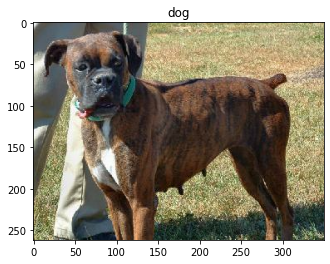

In [ ]:
get_label_name = ds_info.features['label'].int2str

image, label = next(iter(treino_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
resize_e_rescale = keras.Sequential(
    [
     layers.experimental.preprocessing.Resizing(150, 150),
     layers.experimental.preprocessing.Rescaling(1./255)
    ]
)

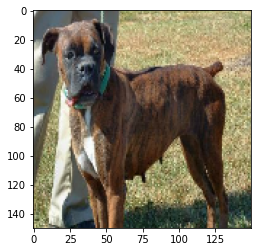

In [ ]:
resultado = resize_e_rescale(image)
_ = plt.imshow(resultado)

In [ ]:
# testando o uso de rescale

print("Valores minimos e maximos de pixel:", resultado.numpy().min(), ' e ',resultado.numpy().max())

Valores minimos e maximos de pixel: 0.0  e  1.0


In [ ]:
#Definindo um shape so para entrar na rede, a camada de resize e rescale no modelo termina a normalizacao
size = (180, 180)

treino_ds = treino_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validacao_ds = validacao_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
batch_size = 32

treino_ds = treino_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validacao_ds = validacao_ds.cache().batch(batch_size).prefetch(buffer_size=10)
teste_ds = teste_ds.cache().batch(batch_size).prefetch(buffer_size=10)

## **Mitigando o *overfitting* com aumento de dados aleatórios**

In [ ]:
aumento_de_dados = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        # layers.experimental.preprocessing.RandomHeight(0.2),
        # layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

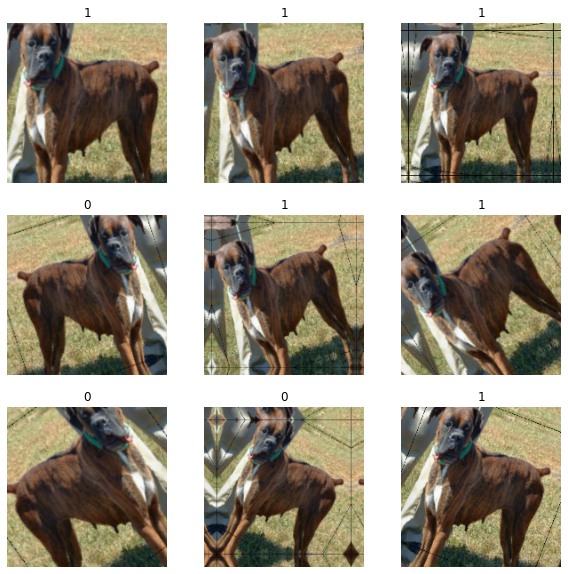

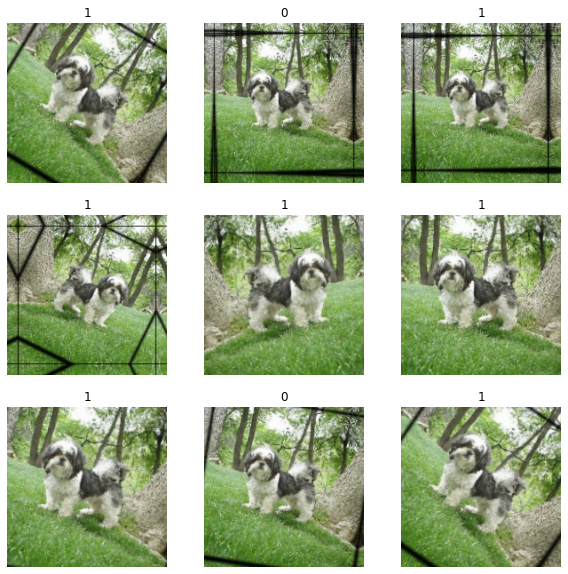

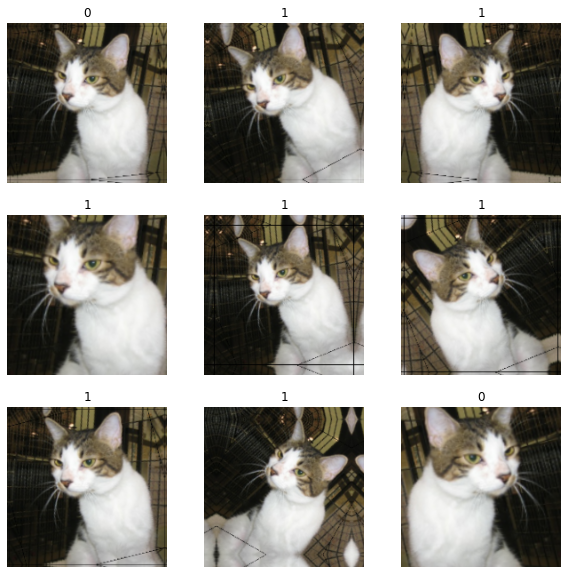

In [ ]:
# testando o efeito de transformacao das imagens

for images, labels in treino_ds.take(3):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = aumento_de_dados(tf.expand_dims(first_image, 0), training=True)
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## **OBS: Surgiu um *tradeoff* entre atender o requisito de utilizar *resize* e *rescale* como camada no modelo e a otimização(*batch size, cache, prefetch, shuffle*, etc) do conjunto de treino. Dessa forma, para não ter mais erros de compilação e perda de tempo, decidi deixar os conjuntos sem otimização.**

# **Implementação do Modelo ResNet18**

### **Imagens extraídas do Paper 'Deep Residual Learning for Image Recognition (He, Kaiming et al, 2015)**

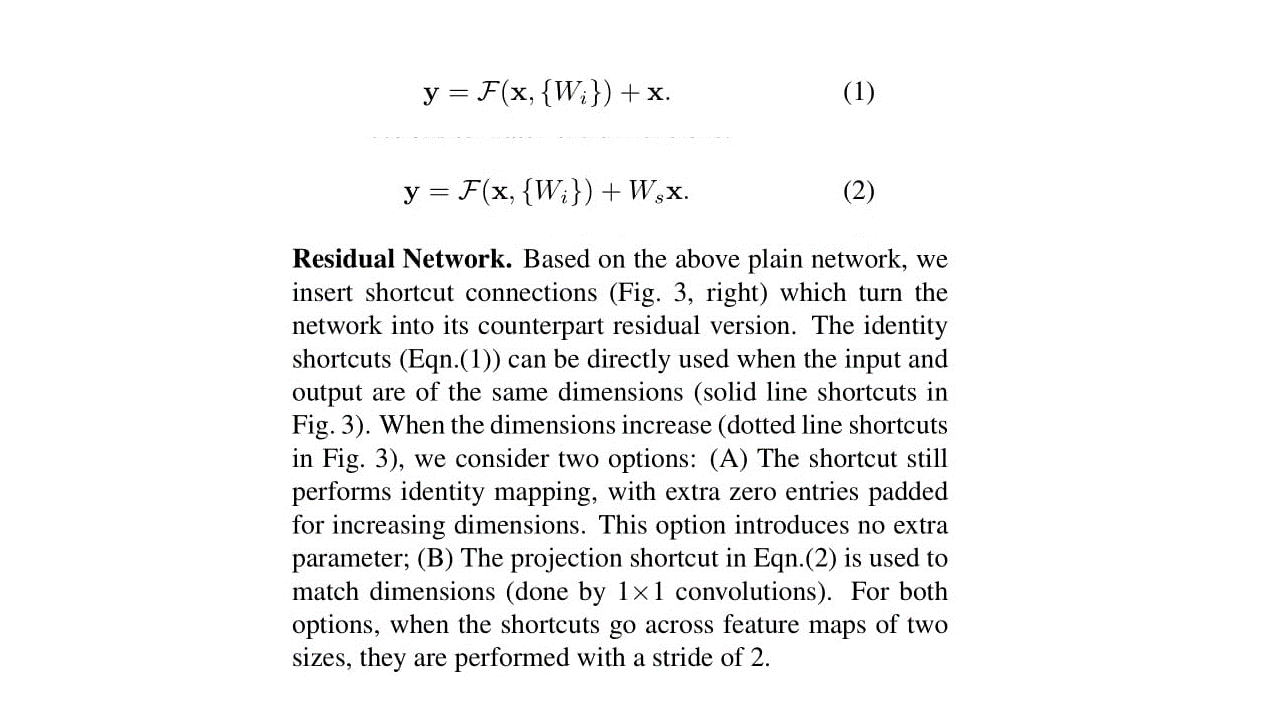

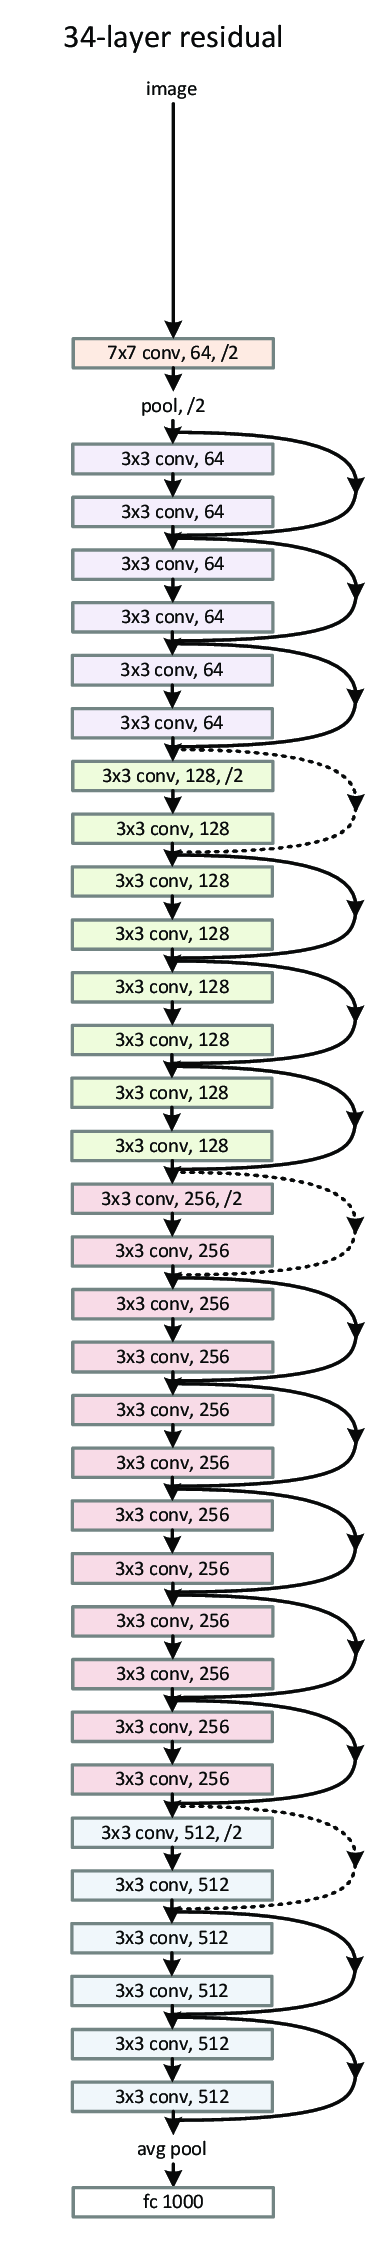

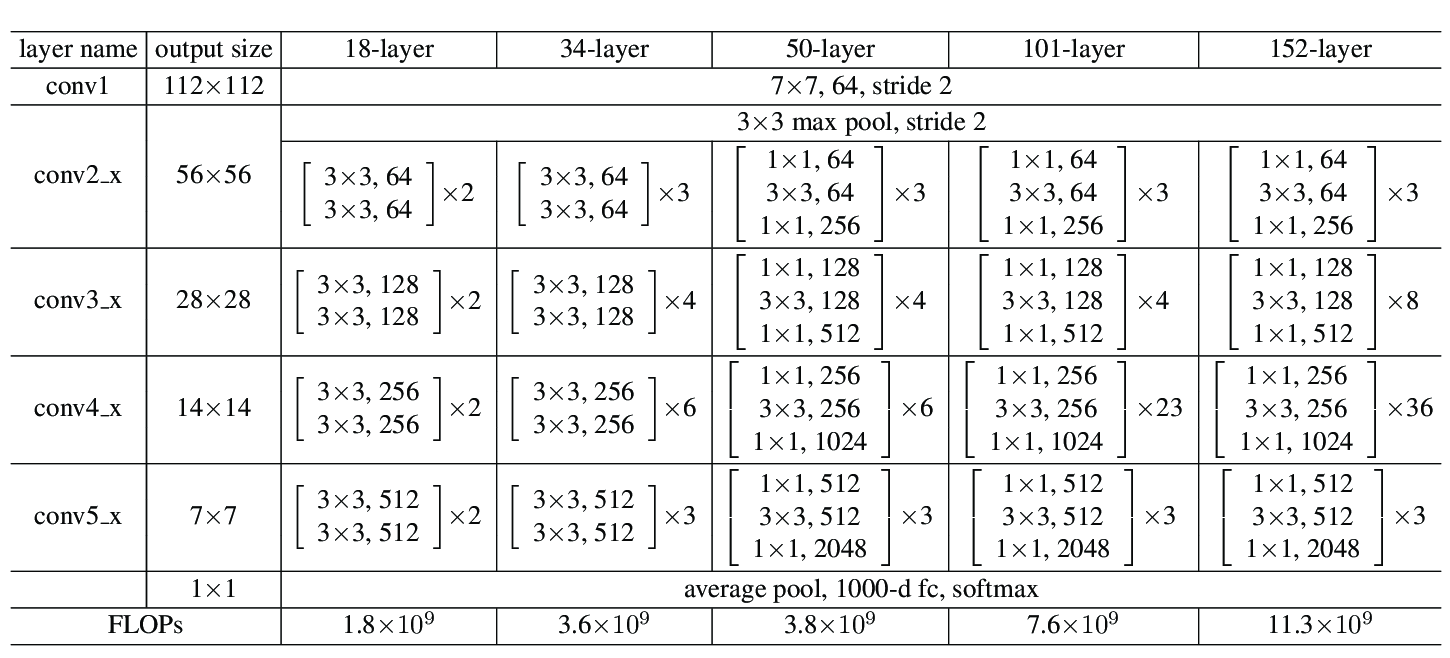

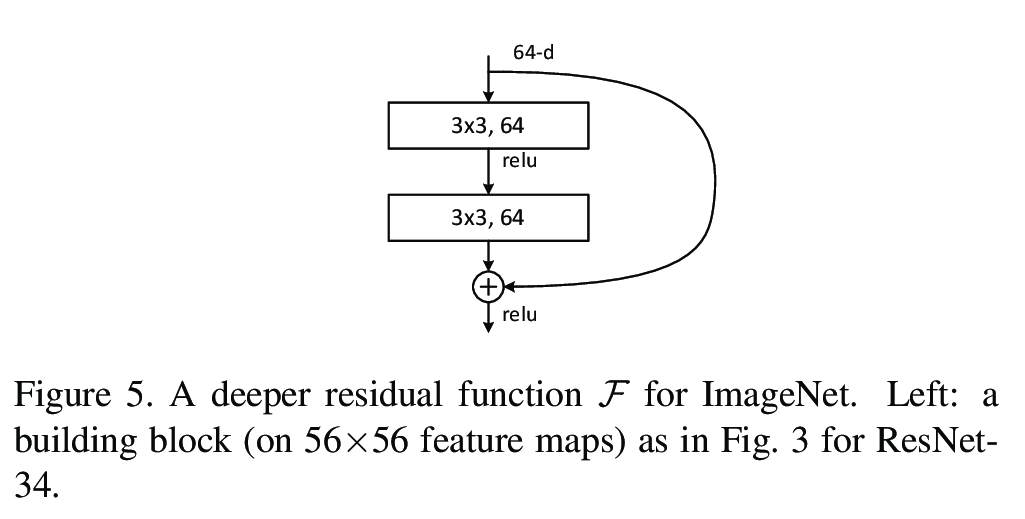

### **O código abaixo foi uma adaptação do modelo ResNet50 do criador do Keras, François Chollet**

https://github.com/fchollet/deep-learning-models/blob/master/resnet50.py

### **As adaptações (simplificações) foram baseadas nos requisitos que constam no Paper**

### **Implementação de bloco residual basico**

In [ ]:
def bloco_basico(X, filtros, passo, bloco):

    # definindo nome base (prefixo e sufixo)
    conv_nome_base = 'residual' + str(passo) + bloco
    bn_nome_base = 'batch_norm' + str(passo) + bloco

    # Filtros de recuperacao
    F1, F2 = filtros

    # Salva o valor de entrada 
    X_shortcut = X

    # primeiro componente do caminho principal
    X = Conv2D(filters=F1, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_nome_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_nome_base + '2a')(X)
    X = Activation('relu')(X)

    # segundo componente do caminho principal
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_nome_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_nome_base + '2b')(X)

    # Passo final: adicionar valor de atalho no caminho principal e passar isso para uma func RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### **Implementação de bloco residual convolucional**

In [ ]:
def bloco_convolucional(X, filtros, passo, bloco, s=2):

    # definindo nome base (prefixo e sufixo)
    conv_nome_base = 'conv_res' + str(passo) + bloco
    bn_nome_base = 'batch_norm' + str(passo) + bloco

    # filtros de recuperacao
    F1, F2 = filtros

    # Salvar valores da entrada
    X_shortcut = X

    # caminho principal
    # primeiro componente do caminho principal 
    X = Conv2D(filters=F1, kernel_size=(3, 3), strides=(s, s), padding='valid', name=conv_nome_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_nome_base + '2a')(X)
    X = Activation('relu')(X)

    # segundo componente do caminho principal
    X = Conv2D(filters=F2, kernel_size=(3, 3), strides=(1, 1), padding='same', name=conv_nome_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_nome_base + '2b')(X)

    # caminho de atalho
    X_shortcut = Conv2D(filters=F2, kernel_size=(3, 3), strides=(s, s), padding='valid', name=conv_nome_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=2, name=bn_nome_base + '1')(X_shortcut)

    # passo final (bloco_conv): adicionar valor de atalho ao caminho principal e passar isso para uma func RELU
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### **Implementação do modelo ResNet18 para o dataset cats_and_dogs** 

In [ ]:
def ResNet18(input_shape=(180, 180, 3), classes=2):

    # Definindo a entrada como um tensor com o formato do vetor input_shape
    X_input = Input(input_shape)

    # camada de resize e rescale
    X = resize_e_rescale(X_input)

    # aumento de dados como camada no modelo
    X = aumento_de_dados(X)

    # zero-padding
    X = ZeroPadding2D((3, 3))(X)

    # passo 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='batch_norm_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # passo 2
    X = bloco_convolucional(X, filtros=[64, 64], passo=2, bloco='a', s=1)
    X = bloco_basico(X, [64, 64], passo=2, bloco='b')  

    # passo 3
    X = bloco_convolucional(X, filtros=[128, 128], passo=3, bloco='a', s=2)
    X = bloco_basico(X, [128, 128], passo=3, bloco='b')

    # passo 4
    X = bloco_convolucional(X, filtros=[256, 256], passo=4, bloco='a', s=2) 
    X = bloco_basico(X, [256, 256], passo=4, bloco='b')

    # passo 5
    X = X = bloco_convolucional(X, filtros=[512, 512], passo=5, bloco='a', s=2)
    X = bloco_basico(X, [512, 512], passo=5, bloco='b')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    # saida
    X = Flatten()(X)
    saida = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # modelo
    model = Model(inputs=X_input, outputs=saida, name='ResNet18')

    return model

In [ ]:
rn18 = ResNet18(input_shape=(180,180,3), classes=2)

In [ ]:
rn18.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (150, 150, 3)        0           input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 3 0           sequential[0][0]                 
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           sequential_1[0][0]               
___________________________________________________________________________________________

In [ ]:
rn18.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

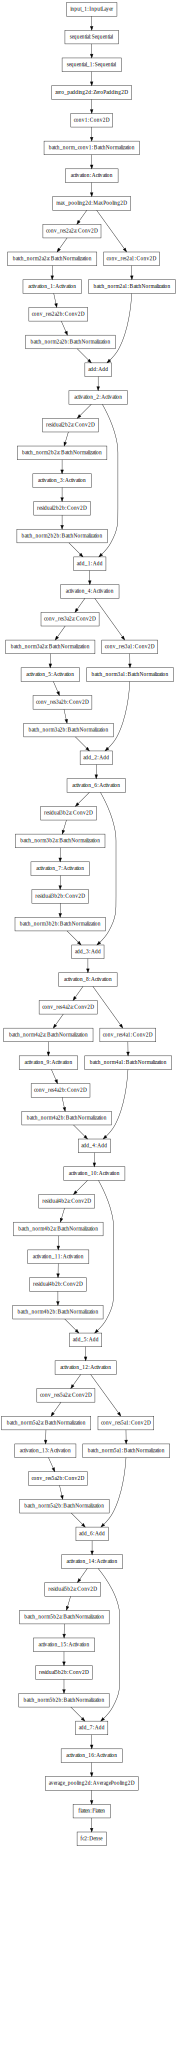

In [ ]:
#visualizando as camadas e atalhos da resnet18
plot_model(rn18, to_file='ResNet18_model.png')
SVG(model_to_dot(rn18, dpi=65).create(prog='dot', format='svg'))

### **Treinando o modelo ResNet18**

In [ ]:
# EPOCHS = 20
EPOCHS = 3
history = rn18.fit(treino_ds, epochs=EPOCHS, validation_data=validacao_ds)

Epoch 1/3


582/582 [==============================] - ETA: 0s - loss: 7.6566 - accuracy: 0.4958WARNING:tensorflow:Model was constructed with shape (262, 350, 3) for input Tensor("resizing_input:0", shape=(262, 350, 3), dtype=uint8), but it was called on an input with incompatible shape (None, 180, 180, 3).


582/582 [==============================] - 34s 58ms/step - loss: 7.6566 - accuracy: 0.4958 - val_loss: 7.6702 - val_accuracy: 0.5185
Epoch 2/3
582/582 [==============================] - 27s 46ms/step - loss: 7.6682 - accuracy: 0.4961 - val_loss: 7.6702 - val_accuracy: 0.5185
Epoch 3/3
582/582 [==============================] - 27s 46ms/step - loss: 7.6682 - accuracy: 0.4961 - val_loss: 7.6702 - val_accuracy: 0.5185


### **Plotagem da acurácia e *loss***

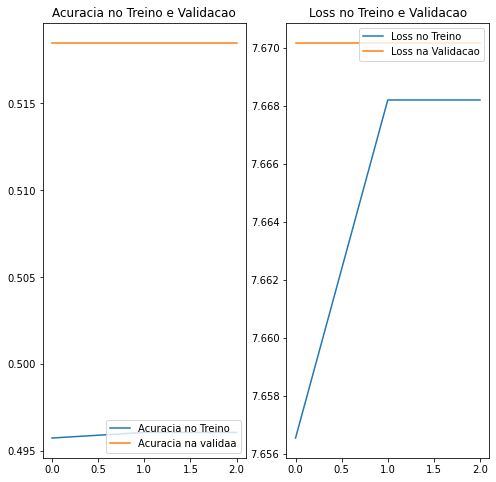

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acuracia no Treino')
plt.plot(epochs_range, val_acc, label='Acuracia na validaa')
plt.legend(loc='lower right')
plt.title('Acuracia no Treino e Validacao')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss no Treino')
plt.plot(epochs_range, val_loss, label='Loss na Validacao')
plt.legend(loc='upper right')
plt.title('Loss no Treino e Validacao')
plt.show()

### ***Predict***

In [ ]:
# teste_ds = teste_ds.map(lambda x, y: (tf.image.resize(x, (180,180)), y))
# teste_ds = teste_ds.map(lambda x, y: (resize_e_rescale(x), y))
# predicao = rn18.predict(teste_ds)
# predicao = rn18.predict(teste_ds[0])
# predicao

# **Como observado o modelo não está convergindo, muito provavelmente devido a algo de errado com as camadas de aumento de dados e *resize e rescale* dentro do modelo conforme alerta abaixo no momento do treino:**

## *WARNING:tensorflow:Model was constructed with shape...*

# **Em respeito ao prazo de entrega, não tive tempo de tentar solucionar o problema de convergência do modelo e nem o problema de *predict*.**

# **Conto com a compressão da equipe de professores em relação aos fatos supracitados.**